In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.fft
import matplotlib.pylab as plt

from pyinverse.grid import RegularAxis, FFTRegularAxis, RFFTRegularAxis

From e.g., Blahut we have $\text{rect}(t) \leftrightarrow \text{sinc}(f)$. These functions are defined as
\begin{equation}
\text{rect}(t) =
\begin{cases}
1 & |t| \leq \frac12 \\
0 & \text{otherwise}
\end{cases}
\end{equation}
and
\begin{equation}
\text{sinc}(x) = \frac{\sin\pi x}{\pi x}
\end{equation}
where $\text{sinc}(0) = 1$.

From, e.g., Oppenheim and Schaffer, we have that the DFT of the discrete rect window function of length $L$ is
\begin{equation}
W_r(e^{j\omega}) = \sum_{n=0}^{L-1} e^{-j\omega n} = e^{-j\omega(L-1)/2} \frac{\sin(\omega L/2)}{\sin(\omega /2)}
\end{equation}
Note that $W_r(0) = L$.

The discrete rect window function is defined as
\begin{equation}
w_r(n) = 
\begin{cases}
1 & 0 \leq n < L \\
0 & \text{otherwise}
\end{cases}
\end{equation}

In [3]:
Ts = 0.01
N = 501 # chosen to force zero padding
d = 1/(Ts*N)
t_axis = FFTRegularAxis(N, d=d) 

In [4]:
def rect(t):
    y = np.zeros_like(t)
    y[np.abs(t) <= 0.5] = 1
    return y

In [5]:
y = rect(t_axis)

In [6]:
L = np.count_nonzero(y)
shift = np.argwhere(y > 0)[0][0]

In [7]:
def w_r(n, L):
    y = np.zeros_like(n)
    y[(0 <= n) & (n < L)] = 1
    return y

In [8]:
def W_r(omega, L):
    y = np.empty_like(omega, dtype=np.complex)
    y[omega == 0] = L
    I = omega != 0
    y[I] = np.exp(-1j*omega[I]*(L-1)/2) * np.sin(omega[I]*L/2) / np.sin(omega[I]/2)
    return y

<IPython.core.display.Javascript object>


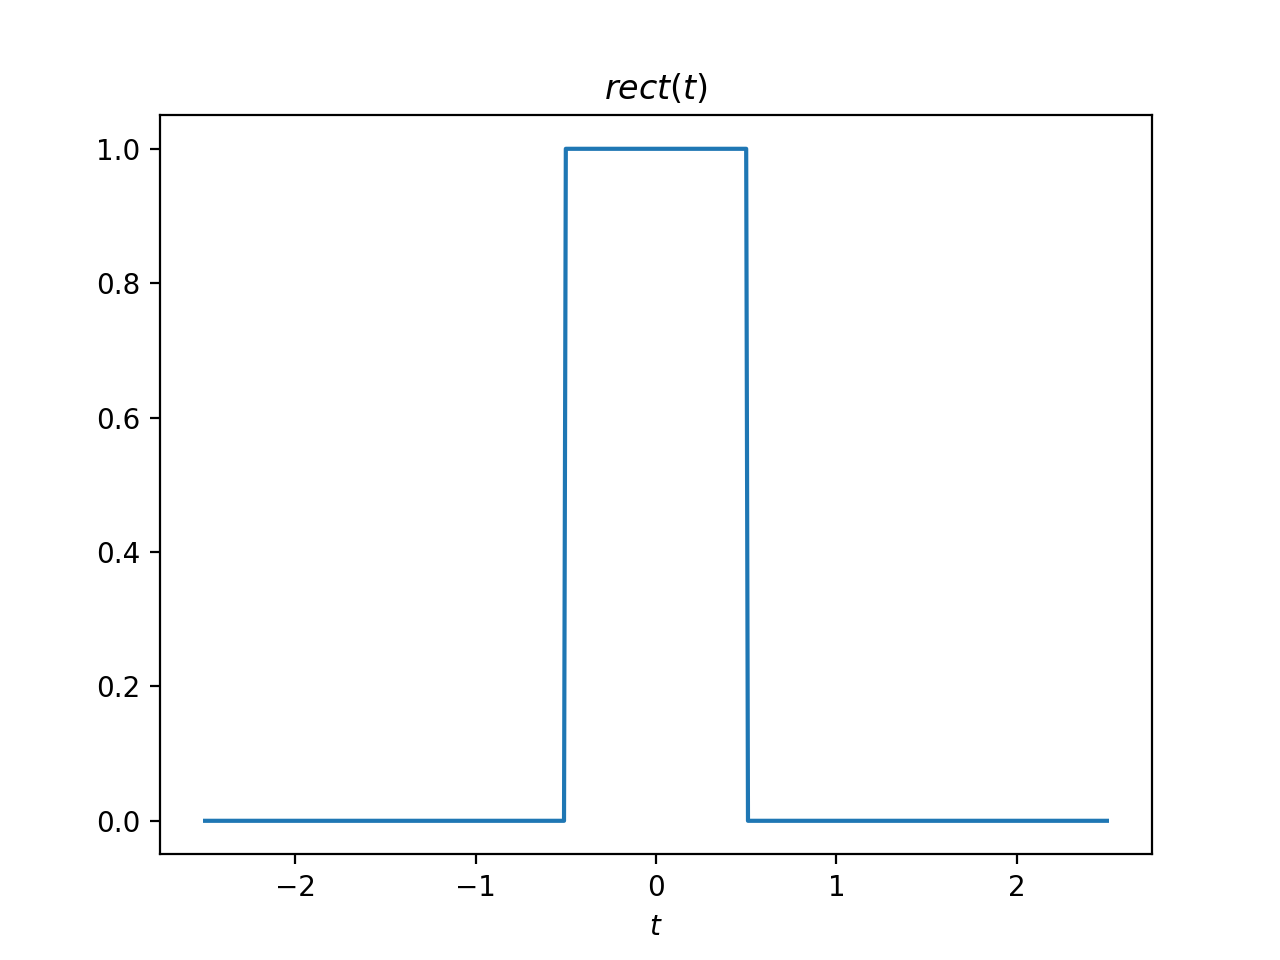

In [9]:
fig, ax = plt.subplots()
ax.plot(t_axis, y)
ax.set_xlabel(r'$t$')
ax.set_title(r'$rect(t)$');

In [10]:
f_axis, Y_ft = t_axis.ft(y)

In [11]:
Fs = 1/Ts
Fn = Fs/2
f = np.linspace(-Fn, Fn, N*8)

In [12]:
Yc_theory = np.sinc(f)

In [13]:
f_axis

FFTRegularAxis(x0=-50.0, T=0.1984126984126984, N=504)

<IPython.core.display.Javascript object>


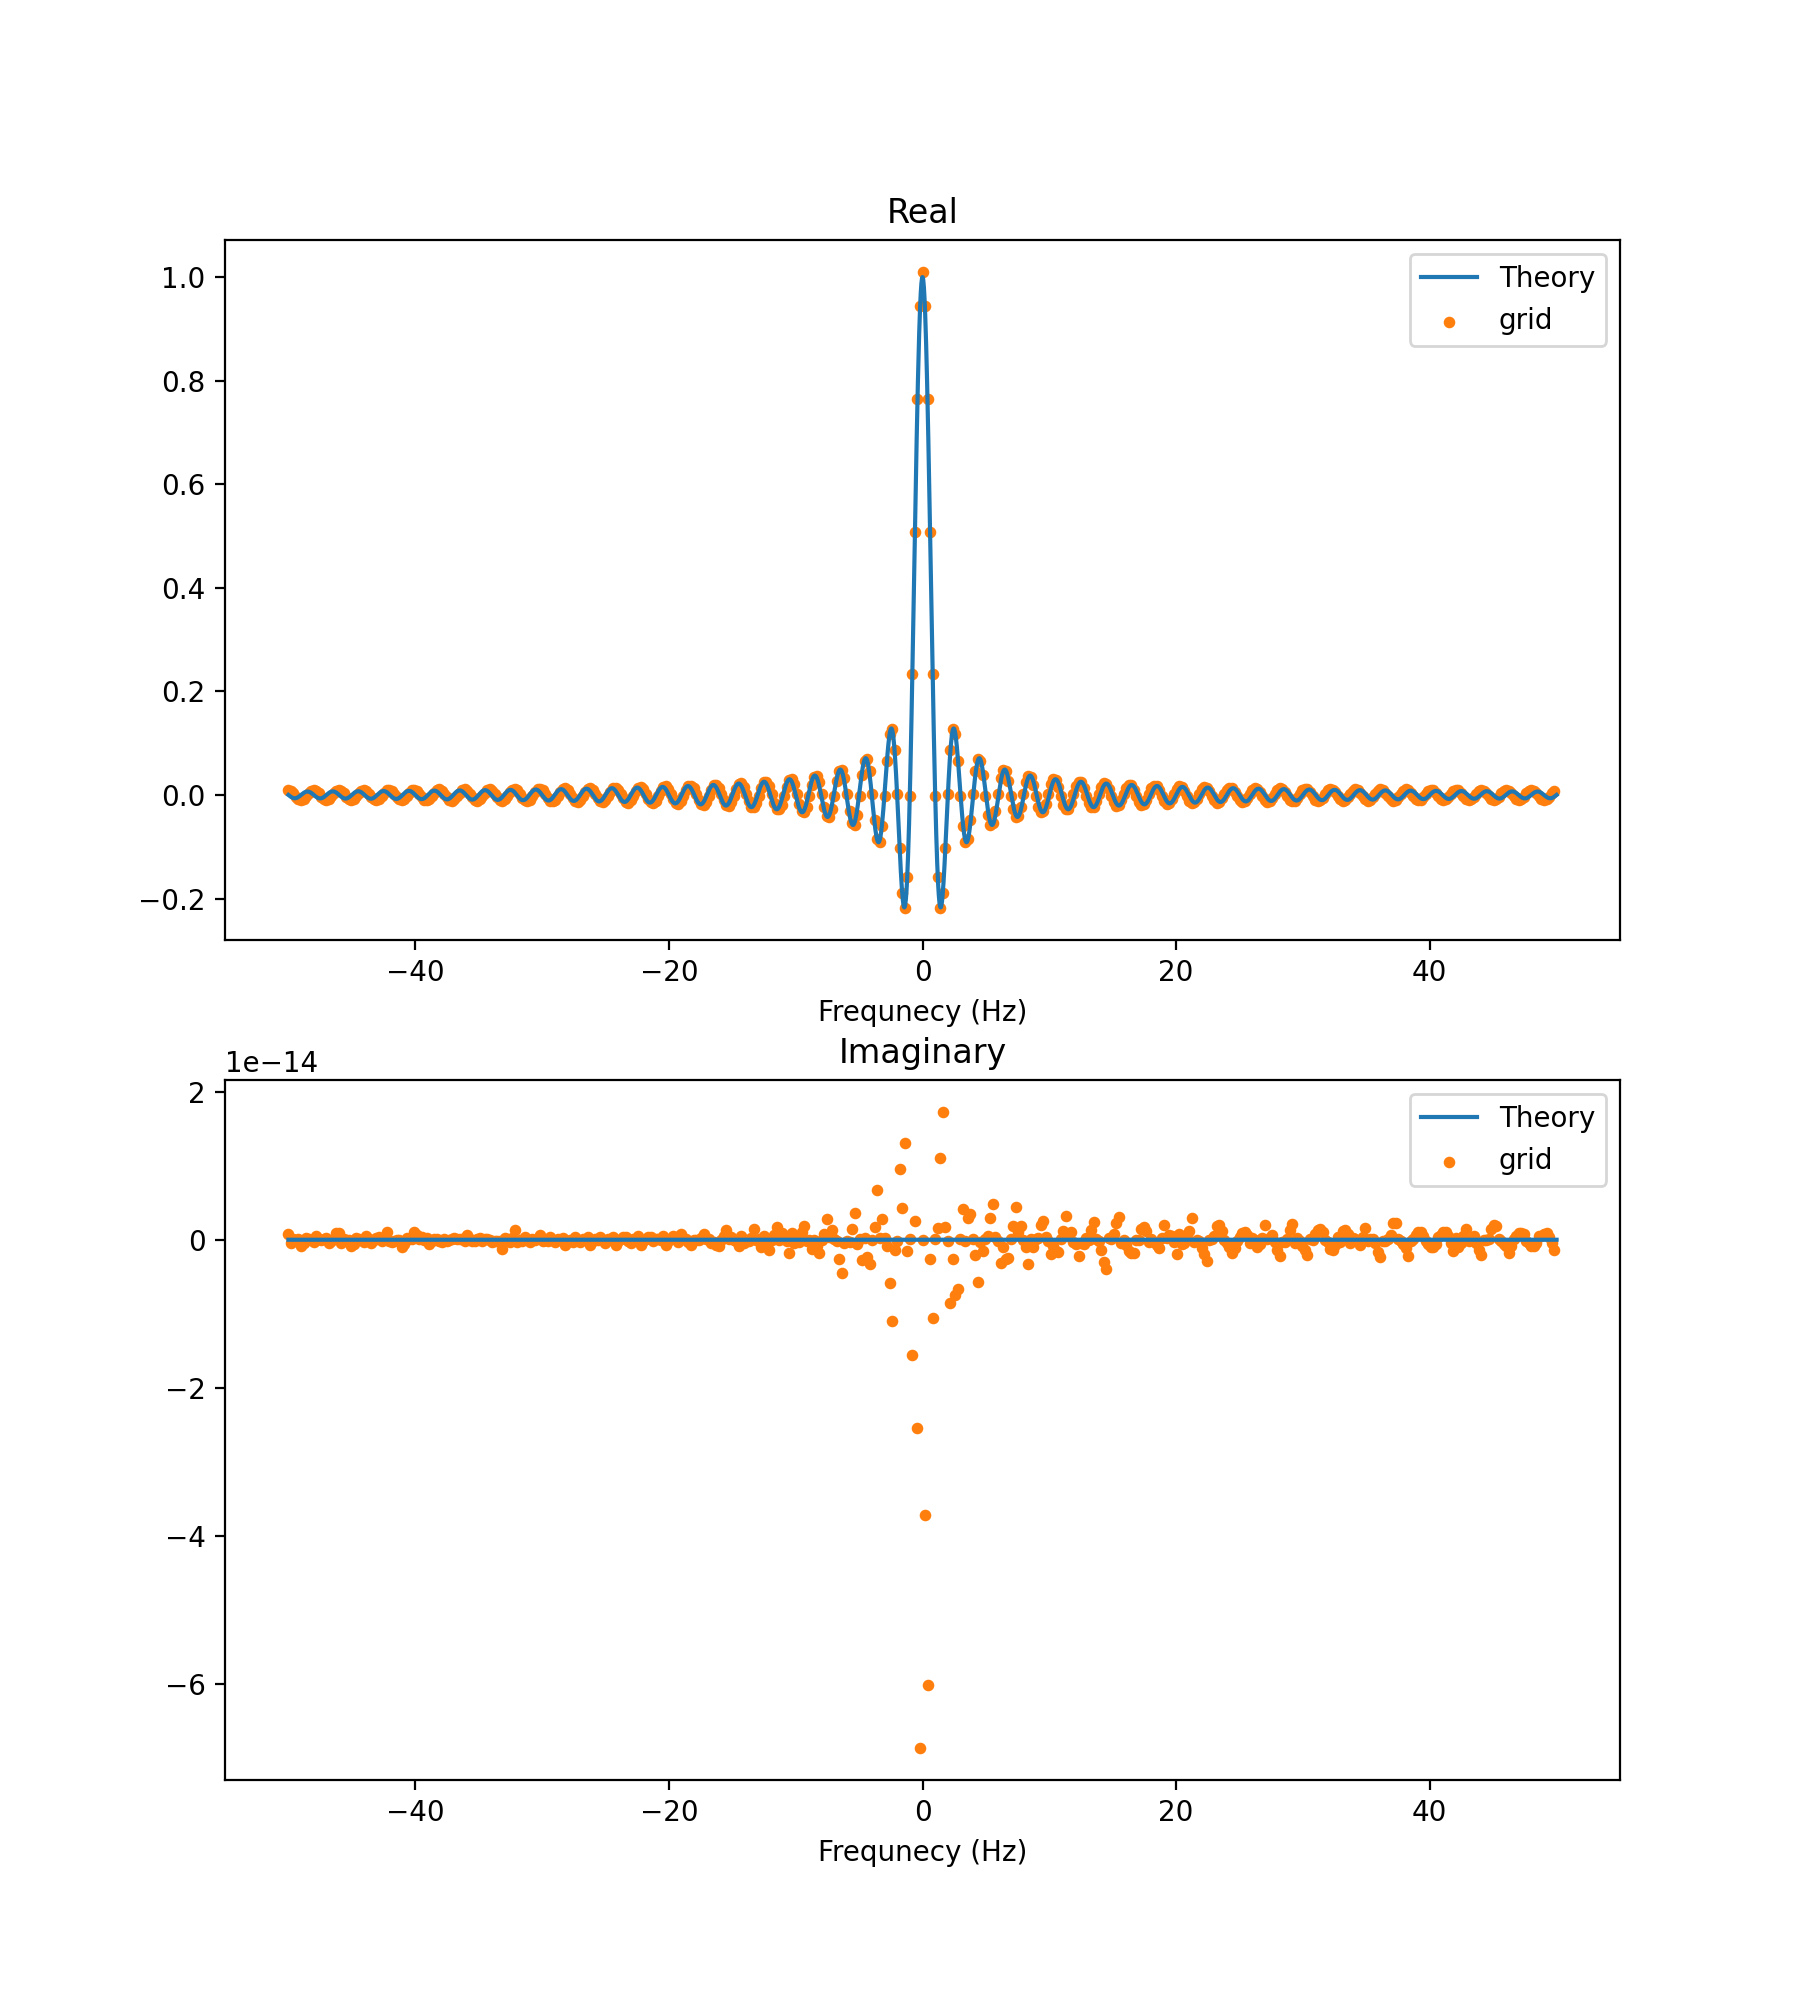

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 10))
ax[0].plot(f, np.real(Yc_theory), label='Theory')
ax[0].scatter(f_axis.centers, np.real(Y_ft), c='C1', s=10, label='grid')
ax[0].legend()
ax[0].set_xlabel('Frequnecy (Hz)')
ax[0].set_title('Real')
ax[1].plot(f, np.imag(Yc_theory), label='Theory')
ax[1].scatter(f_axis.centers, np.imag(Y_ft), c='C1', s=10, label='grid')
ax[1].legend()
ax[1].set_xlabel('Frequnecy (Hz)')
ax[1].set_title('Imaginary');

In [15]:
t_axis_ift, y_ift = f_axis.ift(Y_ft)

In [16]:
t_axis, t_axis_ift

(FFTRegularAxis(x0=-2.5, T=0.01, N=501),
 FFTRegularAxis(x0=-2.5, T=0.01, N=501))

In [17]:
np.max(np.abs(np.imag(y_ift)))
y_ift = np.real(y_ift)

<IPython.core.display.Javascript object>


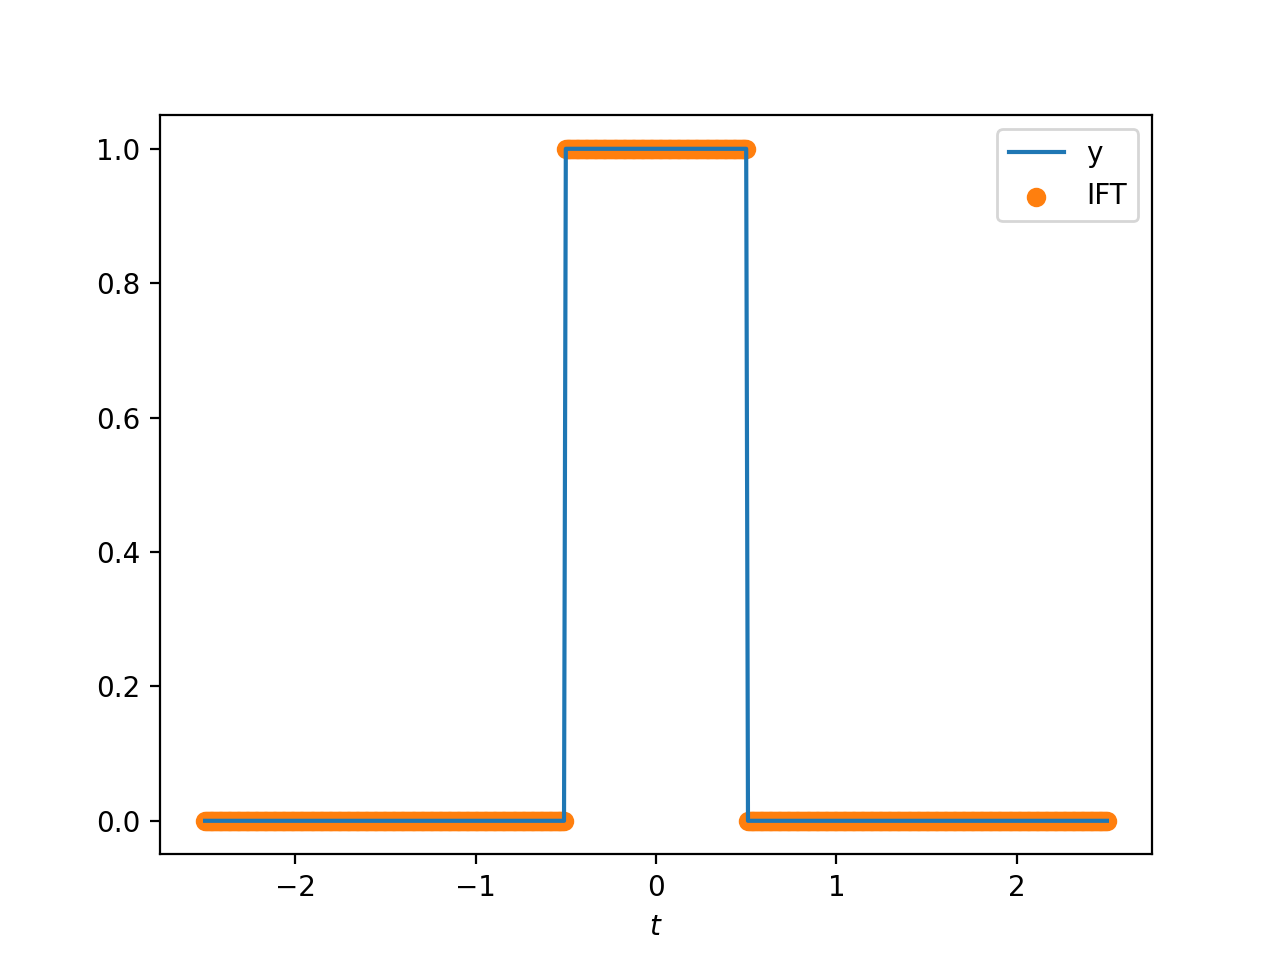

In [18]:
fig, ax = plt.subplots()
ax.plot(t_axis, y, label='y')
ax.scatter(t_axis.centers, y_ift, c='C1', label='IFT')
ax.set_xlabel(r'$t$')
ax.legend();